In [ ]:
!pip install lightfm > dont_show_me_install.txt

# Data processing

In [ ]:
reviews_path = "/content/drive/MyDrive/processed_review_data.parquet"
restaurants_path = "/content/drive/MyDrive/yelp_restaurant_data.csv"

import pandas as pd
from scipy.sparse import coo_matrix
from lightfm import LightFM
from lightfm.data import Dataset
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
plt.style.use('seaborn-v0_8-white')
sns.set_context("talk")

### Remove chains restaurants

Using working threshold is ≤ 3

It is biased towards being more selective

In [ ]:
reviews_df = pd.read_parquet(reviews_path)
restaurants_df = pd.read_csv(restaurants_path)

# Define the threshold for allowed restaurant names
n_chain_threshold = 1

# Define keywords for categorizing restaurant types
grocery_keywords = ['market', 'mart', 'trader joe', 'mariano', 'aldi', 'whole foods', 'save a lot']
liquor_keywords = ['liquor', 'beverage depot']
dessert_keywords = ['cupcake', 'bakery', 'ice cream', 'donut', 'dessert']
coffee_keywords = ['coffee', 'espresso', 'dollop', 'café']

# Function to assign type based on keywords
def assign_type(name):
    name = name.lower()
    if any(k in name for k in grocery_keywords):
        return 'grocery'
    elif any(k in name for k in liquor_keywords):
        return 'liquor'
    elif any(k in name for k in dessert_keywords):
        return 'dessert'
    elif any(k in name for k in coffee_keywords):
        return 'cafe'
    else:
        return 'restaurant'

# Manual tags for specific restaurants
manual_tags = {
    "MrBeast Burger": "ghost_kitchen",
    "GNC": "convenience",

}

# Chain operations together
filtered_restaurants_ids = (
    restaurants_df
    .assign(name_lower=lambda x: x["name"].str.lower())  # Create a lowercase name column
    .loc[lambda x: x["name_lower"].isin(x["name_lower"].value_counts()[lambda y: y <= n_chain_threshold].index)]  # Filter by allowed names
    .assign(type=lambda x: x["name"].apply(assign_type))  # Assign types based on keywords
    .assign(type=lambda x: x.apply(lambda row: manual_tags.get(row['name'], row['type']), axis=1))  # Update types with manual tags
    .loc[lambda x: ~x['type'].isin(['grocery', 'liquor', 'ghost_kitchen', 'convenience'])]  # Drop unwanted types
    .loc[:, ['name', 'id', 'alias']]
    .rename(columns={'id': 'restaurant_id'})
)

# Filter reviews based on the filtered restaurants and join to reviews

user_restaurant_df = pd.merge(
    filtered_restaurants_ids,
    reviews_df,
    on='restaurant_id',
    how='inner'
)

### Check for duplicates

In [ ]:
# --- user-level aggregates ---------------------------------------
user_df = (
    user_restaurant_df.groupby("user_id")
           .agg(avg_weighted_rating_given   = ("weighted_rating_score", "mean"),
                avg_weighted_sentiment_given= ("weighted_sentiment_score", "mean"),
                avg_recency_score           = ("recency_score", "mean"))
)

# --- item-level aggregates ---------------------------------------
import numpy as np

item_df = (
    user_restaurant_df.groupby("restaurant_id")
           .agg(avg_weighted_rating_received   = ("weighted_rating_score", "mean"),
                avg_weighted_sentiment_received= ("weighted_sentiment_score", "mean"),
                review_count    = ("rating", "count"))
           .assign(
               log_review_count=lambda x: np.log(x['review_count']),
               normalized_log_review_count=lambda x: (np.log(x['review_count']) - np.log(x['review_count']).min()) /
                                                      (np.log(x['review_count']).max() - np.log(x['review_count']).min())
           )
           .drop(columns=['review_count', 'log_review_count'])
)



# ------------------------------------------------------------------
# 2.  BUILD  DATASET  OBJECT  AND  FIT  MAPPINGS
# ------------------------------------------------------------------
dataset = Dataset()

dataset.fit(
    users=user_df.index,
    items=item_df.index,
    user_features = [
        "avg_weighted_rating_given",
        "avg_weighted_sentiment_given",
        "avg_recency_score"
    ],
    item_features = [
        "avg_weighted_rating_received",
        "avg_weighted_sentiment_received",
        "normalized_log_review_count"
    ]
)

# ------------------------------------------------------------------
# 3.  INTERACTION  MATRIX   (binary “review exists” signal)
# ------------------------------------------------------------------
interactions_df = (
    user_restaurant_df[["user_id", "restaurant_id"]]
      .drop_duplicates()
      .assign(value=1)
)

(interactions, _) = dataset.build_interactions(
    interactions_df.itertuples(index=False)
)

# ------------------------------------------------------------------
# 4.  USER  &  ITEM  FEATURE  MATRICES
# ------------------------------------------------------------------
# helper: turn a numeric DataFrame into (id, {name: value}) tuples
def df_to_tuples(df, prefix):
    names = df.columns
    for idx, row in df.iterrows():
        yield (idx, {f"{prefix}{n}": row[n] for n in names})

user_features = dataset.build_user_features(
    df_to_tuples(user_df, "")
)

item_features = dataset.build_item_features(
    df_to_tuples(item_df, "")
)

# ------------------------------------------------------------------
# 5.  TRAIN  LIGHTFM  (BPR loss for ranking)
# ------------------------------------------------------------------
model = LightFM(loss="bpr", no_components=32, learning_rate=0.05)
model.fit(interactions,
          user_features=user_features,
          item_features=item_features,
          epochs=10,
          num_threads=4)


# Generating Recommendations

In [ ]:
# ------------------------------------------------------------------
# 6.  EXAMPLE:  RECOMMEND  TOP-5  FOR  ONE  USER
# ------------------------------------------------------------------
import numpy as np

some_user_id = user_restaurant_df[['user_id']].iloc[0].values[0]
uid = dataset.mapping()[0][some_user_id]   # replace with real id
scores = model.predict(
    uid,
    np.arange(len(item_df)),
    user_features=user_features,
    item_features=item_features
)

# spread tuple for clarity
user_map, user_feat_map, item_map, item_feat_map = dataset.mapping()

# invert: internal index -> external restaurant_id
index_to_item = {v: k for k, v in item_map.items()}

top5 = np.argsort(-scores)[:5]
recommended_item_ids = [index_to_item[i] for i in top5]
print("Top-5 recommended restaurants:", recommended_item_ids)

Top-5 recommended restaurants: ['A9Rie2xPng0XqD9oPvDN7w', '8oKRLk54AhYwEaBe7onYog', 'gsI8b6vE33gZtMxt0cr19w', '5q0X5lqAwvscWpp6Zr0c4A', '3vn__BuRUWlJiyOd_Odufw']


In [ ]:
(
    filtered_restaurants_ids
    .loc[filtered_restaurants_ids['restaurant_id'].isin(recommended_item_ids)]
    # .drop_duplicates()
)

,name,restaurant_id,alias
2324,The Green Door Tavern,8oKRLk54AhYwEaBe7onYog,the-green-door-tavern-chicago
2689,Sparrow Coffee Roastery,A9Rie2xPng0XqD9oPvDN7w,sparrow-coffee-roastery-chicago
3156,The Submarine Pier,5q0X5lqAwvscWpp6Zr0c4A,the-submarine-pier-chicago
3933,Gyros Guys,3vn__BuRUWlJiyOd_Odufw,gyros-guys-chicago-2
4320,Home Chef,gsI8b6vE33gZtMxt0cr19w,home-chef-chicago-6


### Check if the recommendation are all just those that got 3 reviews, because 3 is maximum number of reviews in the data

In [ ]:
(
    user_restaurant_df
    .loc[user_restaurant_df['restaurant_id'].isin(recommended_item_ids)]
    .value_counts('name')
    .nlargest()
)

,count
name,
Gyros Guys,3
Home Chef,3
Sparrow Coffee Roastery,3
The Green Door Tavern,3
The Submarine Pier,3


In [ ]:
from lightfm.evaluation import precision_at_k, recall_at_k

# evaluates over entire interaction matrix (can slice to test subset)
p_at_k = precision_at_k(model,
                        test_interactions=interactions,
                        user_features=user_features,
                        item_features=item_features,
                        k=10).mean()

r_at_k = recall_at_k(model,
                     test_interactions=interactions,
                     user_features=user_features,
                     item_features=item_features,
                     k=10).mean()

print(f"Precision@10: {p_at_k:.4f}, Recall@10: {r_at_k:.4f}")

Precision@10: 0.0006, Recall@10: 0.0045


# Model Explainability

In [ ]:
import shap
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Step 1: Build training data
user_ids = list(user_df.index)
item_ids = list(item_df.index)

# Sample 10 random item pairs per user
pairs = []
for u in user_ids:
    sampled_items = np.random.choice(item_ids, size=10, replace=False)
    for i in sampled_items:
        pairs.append((u, i))

X = []
y = []

user_map, _, item_map, _ = dataset.mapping()

for u, i in pairs:
    if u not in user_map or i not in item_map:
        continue

    u_idx = user_map[u]
    i_idx = item_map[i]

    # Concatenate user + item features
    try:
        u_vec = user_df.loc[u].values
        i_vec = item_df.loc[i].values
    except KeyError:
        continue

    x = np.concatenate([u_vec, i_vec])

    # LightFM score
    score = model.predict(u_idx, np.array([i_idx]),
                          user_features=user_features,
                          item_features=item_features)[0]

    X.append(x)
    y.append(score)

X = np.array(X)
y = np.array(y)

print(f"Sampled {len(X)} user-item pairs for surrogate model.")


Sampled 75330 user-item pairs for surrogate model.


In [ ]:
from sklearn.ensemble import RandomForestRegressor
import shap

rf = RandomForestRegressor(n_estimators=50)
rf.fit(X, y)

RandomForestRegressor(n_estimators=50)

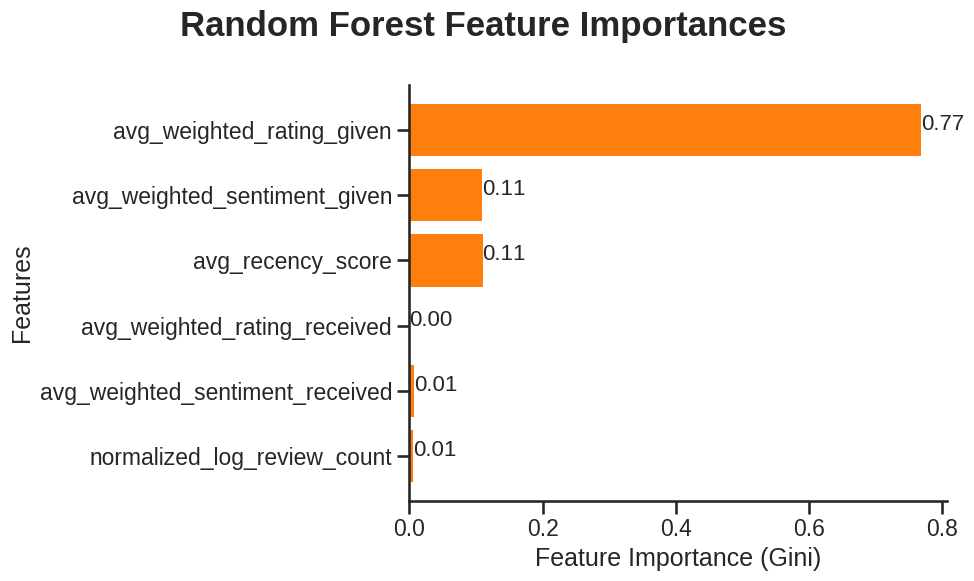

In [ ]:
# Create a figure for the feature importance plot
fig = plt.figure(figsize=(10, 6))
fig.suptitle('Random Forest Feature Importances', fontsize=25, fontweight='bold')  # Title

# Plotting the horizontal bar chart
ax = plt.subplot(1, 1, 1)
ax.barh(feature_names[::-1], importances[::-1], color='#ff7f0e')  # Use the same color as the first plot

# Set labels
ax.set_xlabel("Feature Importance (Gini)", fontsize=18)  # Increased font size
ax.set_ylabel("Features", fontsize=18)  # Increased font size

# Annotate the bars with their importance values
for i, v in enumerate(importances[::-1]):
    ax.text(v, i, f"{v:.2f}", ha='left', fontsize=16)  # Adjusted for horizontal bar

# Remove spines
sns.despine(left=False, bottom=False)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.savefig('random_forest_feature_importances.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
explainer = shap.TreeExplainer(rf)  # use fast tree method

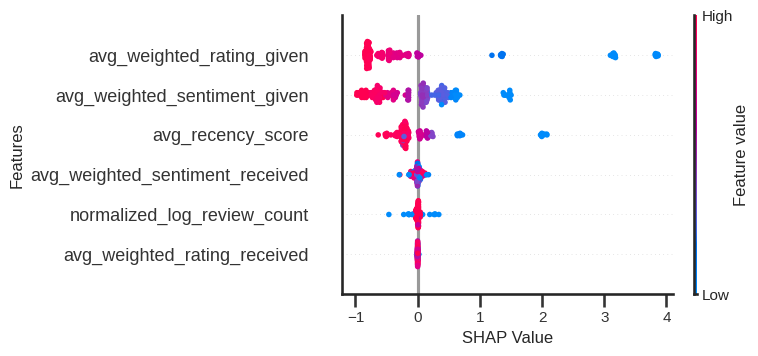

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Set the style
plt.style.use('seaborn-v0_8-white')
sns.set_context("talk")

# Create a figure for the SHAP summary plot
plt.figure(figsize=(10, 6))
plt.title('SHAP Summary Plot', fontsize=25, fontweight='bold')

# Optional: define feature names if not in DataFrame
feature_names = list(user_df.columns) + list(item_df.columns)

# Create the SHAP summary plot
shap.summary_plot(shap_values, X[:200], feature_names=feature_names, show=False)

# Customize the plot
plt.gca().set_xlabel('SHAP Value', fontsize=12)  # Set x-axis label
plt.gca().set_ylabel('Features', fontsize=12)  # Set y-axis label

# Adjust the colors of the points to match the bar plot
plt.gca().collections[0].set_edgecolor('#ff7f0e')  # Set edge color
plt.gca().collections[0].set_facecolor('#ff7f0e')  # Set face color

# Remove spines
sns.despine(left=False, bottom=False)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.savefig('shap_summary_plot.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
rest_df_count, labels, values

(review_count
 1     8.375075
 2     4.127429
 3    87.497495
 Name: proportion, dtype: float64,
 Index([1, 2, 3], dtype='int64', name='review_count'),
 array([ 8.37507514,  4.12742937, 87.49749549]))

# Checking the data to understand failures

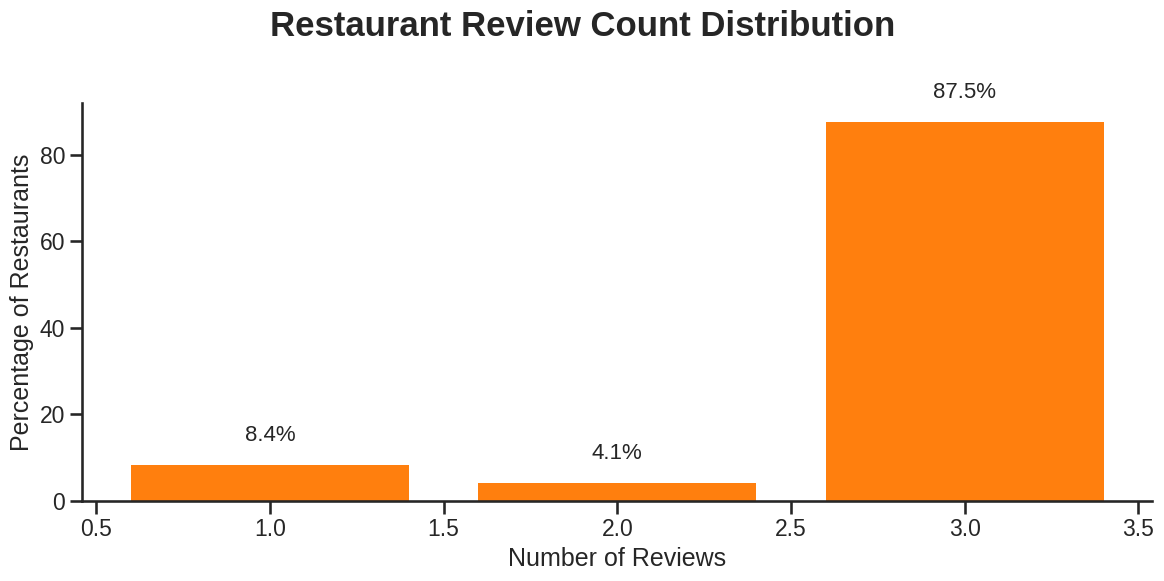

In [ ]:
rest_df_count = (
    reviews_df.groupby("restaurant_id")
            .agg(review_count = ("rating", "count"))
            .loc[:, 'review_count']
            .value_counts(normalize=True)
            .sort_index() * 100
)

rest_df_count

labels = rest_df_count.index
values = rest_df_count.values
# Create a figure with subplots
fig = plt.figure(figsize=(12, 6))
fig.suptitle('Restaurant Review Count Distribution', fontsize=25, fontweight='bold')  # Increased from 24 to 29

# 1. User Review Distribution Plot
ax1 = plt.subplot(1, 1, 1)


ax1.bar(labels, values, color='#ff7f0e')
# ax1.set_title('User Review Count Distribution', fontsize=23)  # Increased from 18 to 23
ax1.set_xlabel('Number of Reviews', fontsize=18)  # Increased from 13 to 18
ax1.set_ylabel('Percentage of Restaurants', fontsize=18)  # Increased from 13 to 18
for i, v in zip(labels, values):
    ax1.text(i, v, f"{v:.1f}%\n", ha='center', fontsize=16)  # Increased from 11 to 16

# Remove spines
sns.despine(left=False, bottom=False)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.savefig('restaurant review count distribution.png', dpi=300, bbox_inches='tight')
plt.show()



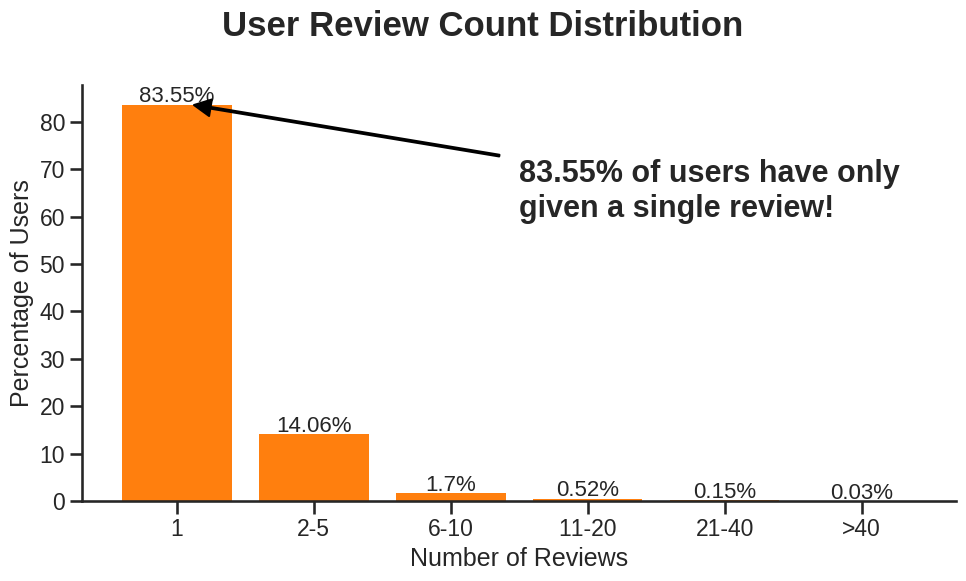

In [ ]:
bins   = [0, 1, 5, 10, 20, 40, np.inf]
labels = ['1', '2-5', '6-10', '11-20', '21-40', '>40']
u_deg  = reviews_df.groupby('user_id').size()
plot_df = (pd.DataFrame({'count': u_deg})
             .assign(bin=pd.cut(u_deg, bins=bins, labels=labels)))
user_distribution = (plot_df.value_counts('bin', normalize=True) * 100).round(2)
user_distribution = user_distribution.to_dict()
labels = list(user_distribution.keys())
values = list(user_distribution.values())

# Set the style
plt.style.use('seaborn-v0_8-white')
sns.set_context("talk")

# Create a figure with subplots
fig = plt.figure(figsize=(10, 6))
fig.suptitle('User Review Count Distribution', fontsize=25, fontweight='bold')  # Increased from 24 to 29

# 1. User Review Distribution Plot
ax1 = plt.subplot(1, 1, 1)


ax1.bar(labels, values, color='#ff7f0e')
# ax1.set_title('User Review Count Distribution', fontsize=23)  # Increased from 18 to 23
ax1.set_xlabel('Number of Reviews', fontsize=18)  # Increased from 13 to 18
ax1.set_ylabel('Percentage of Users', fontsize=18)  # Increased from 13 to 18
for i, v in enumerate(values):
    ax1.text(i, v + 0.5, f"{v}%", ha='center', fontsize=16)  # Increased from 11 to 16
ax1.annotate(f'{values[0]}% of users have only\ngiven a single review!',
             xy=(0, 84.1), xytext=(2.5, 60),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.2),
             fontsize=22, fontweight='bold')  # Increased from 20 to 25

# Remove spines
sns.despine(left=False, bottom=False)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.savefig('user review count distribution.png', dpi=300, bbox_inches='tight')
plt.show()

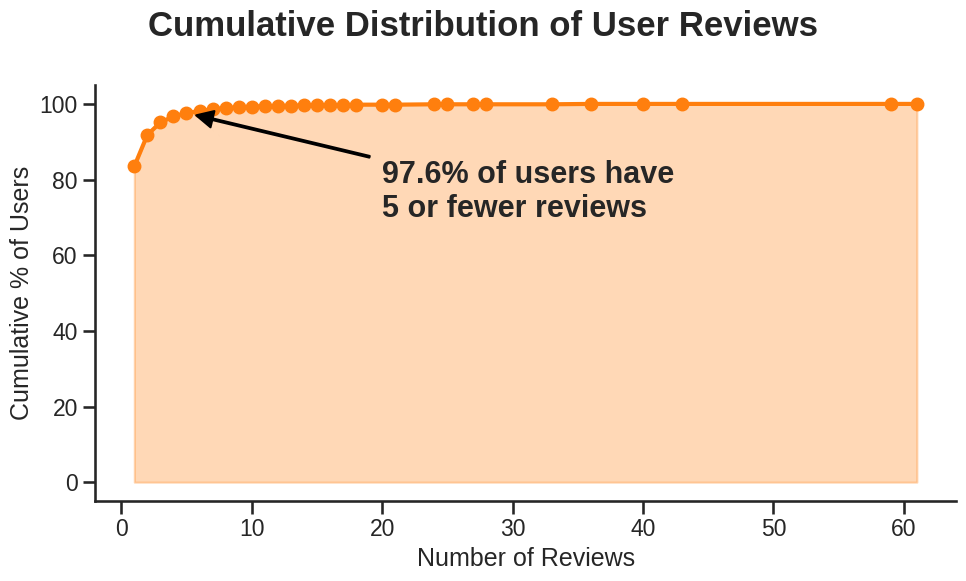

In [ ]:
# 2. Cumulative Distribution Plot
fig = plt.figure(figsize=(10, 6))
ax2 = plt.subplot(1, 1, 1)
cdf = u_deg.value_counts().sort_index().cumsum()
cdf = (cdf / cdf.max()).round(3) * 100
x_vals = list(cdf.index)
y_vals = list(cdf.values)
ax2.plot(x_vals, y_vals, marker='o', linestyle='-', linewidth=3, color='#ff7f0e')
ax2.fill_between(x_vals, y_vals, alpha=0.3, color='#ff7f0e')
fig.suptitle('Cumulative Distribution of User Reviews', fontsize=25, y=0.98, fontweight='bold')  # Increased from 24 to 29
ax2.set_xlabel('Number of Reviews', fontsize=18)  # Increased from 13 to 18
ax2.set_ylabel('Cumulative % of Users', fontsize=18)  # Increased from 13 to 18
# ax2.grid(True)
ax2.annotate(f'{y_vals[4]}% of users have\n5 or fewer reviews',
             xy=(5, y_vals[4]), xytext=(20, 70),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.2),
             fontsize=22, fontweight='bold')  # Increased from 20 to 25

sns.despine(left=False, bottom=False)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.savefig('cumulative distribution of users reviews.png', dpi=300, bbox_inches='tight')
plt.show()

<ipython-input-144-607b351c4c29>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=values, palette= ['red', 'lightgray'] )


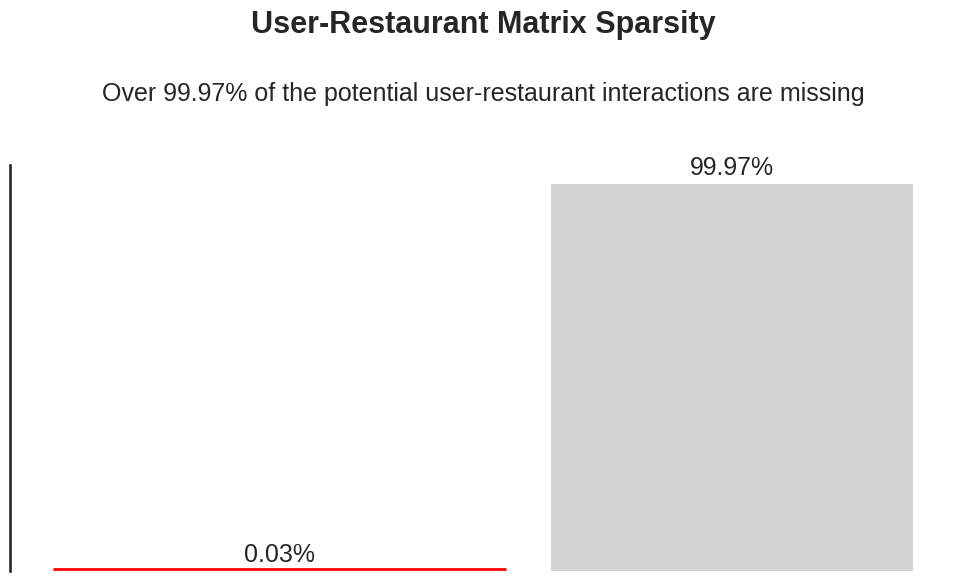

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data for matrix sparsity
matrixSparsity = [
    { "label": "Filled cells (reviews)", "value": 0.03 },
    { "label": "Empty cells (no data)", "value": 99.97 },
]

# Extract labels and values
labels = [item["label"] for item in matrixSparsity]
values = [item["value"] for item in matrixSparsity]

# Create a bar plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=labels, y=values, palette= ['red', 'lightgray'] )
plt.hlines(y=0.5, xmin=-0.5, xmax=0.5, color='red', linewidth=2)
# Add title and labels
plt.title("Matrix Sparsity", fontsize=20)  # Increased from default to 20
plt.xlabel("Cell Type", fontsize=15)  # Increased from default to 15
plt.ylabel("Percentage", fontsize=15)  # Increased from default to 15

# Add value annotations on the bars
for i, v in enumerate(values):
    plt.text(i, v + 1, f"{v}%", ha='center', va='bottom', fontsize=18)  # Increased from default to 12

# Add a text annotation for the filled cells
# plt.text(0, values[0] / 2 + 5, f"Only ~{values[0]:.2f}% filled cells", ha='center', va='center', color='black', fontsize=12, bbox=dict(facecolor='white', edgecolor='lightgray', boxstyle='round,pad=0.5'))

# Remove axis labels and ticks for a cleaner look
plt.xlabel(None)
plt.ylabel(None)
plt.xticks([])
plt.yticks([])

# Set the title
plt.suptitle("User-Restaurant Matrix Sparsity", fontsize=22, fontweight='bold')
plt.title("Over 99.97% of the potential user-restaurant interactions are missing\n\n", fontsize=18)

# Remove spines
sns.despine(left=False, bottom=True)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.savefig('user-restaurant-matrix-sparsity.png', dpi=300, bbox_inches='tight')
plt.show()

Text(0.5, 1.0, 'Edge-feature correlation')

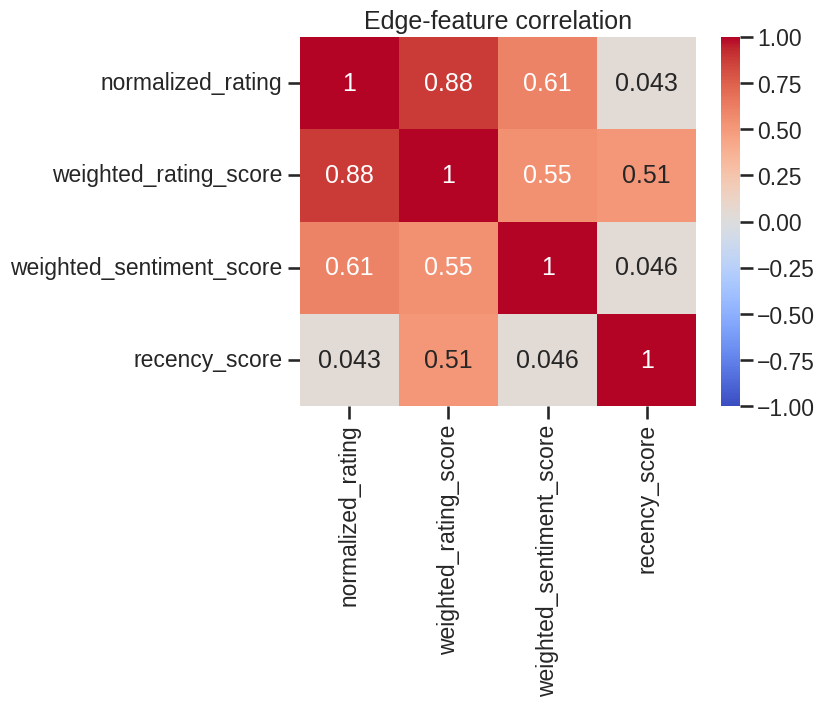

In [ ]:
cols = ['normalized_rating','weighted_rating_score',
        'weighted_sentiment_score','recency_score']
corr = reviews_df[cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Edge-feature correlation')

In [ ]:
restaurants_df2 = pd.read_parquet('/content/drive/MyDrive/processed_restaurant_data.parquet')
restaurants_df2.explode('categories_list').value_counts('categories_list')[:10]
restaurants_df2.columns

Index(['id', 'name', 'categories', 'rating', 'review_count', 'latitude',
       'longitude', 'categories_list', 'log_review_count',
       'normalized_rating_restaurants', 'normalized_log_review_count',
       'popularity_score', 'wilson_score', 'normalized_wilson_score',
       'normalized_latitude', 'normalized_longitude'],
      dtype='object')

### Some map visualization

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Load your restaurant DataFrame
restaurants_df2 = pd.read_parquet('/content/drive/MyDrive/processed_restaurant_data.parquet')
restaurants_clean = restaurants_df2[
    (restaurants_df2["latitude"].between(41.6, 42.1)) &
    (restaurants_df2["longitude"].between(-87.9, -87.5))
]

import plotly.express as px
import plotly.io as pio
pio.renderers.default = "colab"  # or "browser"

fig = px.scatter_mapbox(
    restaurants_clean,
    lat="latitude", lon="longitude",
    mapbox_style="carto-positron",
    zoom=10,
    height=600,
    opacity=0.5,
)
fig.update_traces(marker=dict(color='orange'))
fig.show()

In [ ]:
# number of restaurants, users and interactions; each review is an interaction and there can be multiple of them

print(f'Number of users: {len(reviews_df.user_id.unique())}\n')
temp_df = pd.merge(reviews_df, restaurants_df, left_on='restaurant_id', right_on='id', how='inner')
print(f'Number of restaurants: {len(temp_df.name.unique())}\n')
print(f'Interactions between users and restaurants: {len(temp_df)}')

Number of users: 9493

Number of restaurants: 4266

Interactions between users and restaurants: 13931


# Graph Based Model

In [ ]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.6.0+cu124.html > install.txt
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.6.0+cu124.html > install.txt
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.6.0+cu124.html > install.txt
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-2.6.0+cu124.html > install.txt
!pip install pyg-lib -f https://data.pyg.org/whl/torch-2.6.0+cu124.html > install.txt
!pip install torch-geometric > install.txt

In [ ]:
import torch
import torch_geometric
from torch_geometric.data import HeteroData
from torch_geometric.transforms import RandomLinkSplit, ToUndirected
from torch_geometric.loader import LinkNeighborLoader
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, to_hetero
from sklearn.metrics import roc_auc_score, average_precision_score

print("Torch version:", torch.__version__)
print("Torch Geometric version:", torch_geometric.__version__)
print("CUDA available:", torch.cuda.is_available())

Torch version: 2.6.0+cu124
Torch Geometric version: 2.6.1
CUDA available: False


In [ ]:
user_df.sample(3)

,avg_weighted_rating_given,avg_weighted_sentiment_given,avg_recency_score
user_id,,,
WVioM1m1VdHxQji80JS2wA,0.792166,0.238286,0.984332
G0GaLbHDRl1PS-EJvEvZ3g,0.781625,0.392452,0.963250
QkHdaFNZU0yReDNHhHazcw,0.346585,0.135618,0.693171


In [ ]:
item_df.sample(3)

,avg_weighted_rating_received,avg_weighted_sentiment_received,normalized_log_review_count
restaurant_id,,,
IWwC0x9oZ3j8fqTOLpSWVQ,0.893201,0.289014,1.0
60Dx0YlAo8Fn6bxgn03RpQ,0.861981,0.587902,0.0
U0srsr4F2BxU_5599fsHUg,0.622967,0.379180,1.0


In [ ]:
user_restaurant_df.sample(2)

,name,restaurant_id,alias,review_id,rating,text,time_created,user_id,user_name,bert_sentiment,bert_score,mapped_sentiment,weighted_sentiment_score,days_since_review,recency_score,normalized_rating,weighted_rating_score
8115,Tepalcates,vhR0uUVBmAO2f7VfrxMUog,tepalcates-chicago,ZkT31Y6UD8cpxRfSrnOR7w,5,We went today for the first time and it was so...,2023-02-13 19:49:05,KKOkfPBkiZhJ3_Rr26NGVg,Iskui D.,5 stars,0.764031,positive,0.764031,817.133404,0.887185,0.8,0.843592
8666,Conscious Plates,IMrRANFRfrDOgmTj4D7mRw,conscious-plates-chicago,xKrtxPMt_awEyImGnqbd8g,3,Very very MEH\nI was so excited to try this pl...,2024-11-20 15:38:54,XUwYlVRuyoImgtaw8Cjztg,Bianka M.,2 stars,0.560282,negative,0.224113,171.307142,0.976349,0.4,0.688174


## Build Graph

In [ ]:
# Create mappings for user and restaurant IDs
# keep only those restaurants that have at least one review
# including isolated restaurants does not contribute because there is no message passing

user_idx = {uid: i for i, uid in enumerate(user_df.index)}
item_idx = {rid: i for i, rid in enumerate(item_df.index)}

edges = []

for _,  row in user_restaurant_df.iterrows():
    uid = user_idx[row['user_id']]
    rid = item_idx[row['restaurant_id']]
    edges.append([uid, rid])

user_nodes = torch.tensor(user_df.values, dtype=torch.float)
restaurant_nodes = torch.tensor(item_df.values, dtype=torch.float)

edge_idx = torch.tensor(edges, dtype=torch.long).t().contiguous()


graph = HeteroData()

graph['user'].x = user_nodes
graph['restaurant'].x = restaurant_nodes
graph['user', 'review', 'restaurant'].edge_index = edge_idx

graph = ToUndirected()(graph)
graph

HeteroData(
  user={ x=[7533, 3] },
  restaurant={ x=[3848, 3] },
  (user, review, restaurant)={ edge_index=[2, 10703] },
  (restaurant, rev_review, user)={ edge_index=[2, 10703] }
)

## Create train, test, val

In [ ]:
batch_size = 128
# for train negative edges are sampled dynamically when negative edges are created
# during data loading, while val and test negative edges are fixed for reproducibility

train_val_test_split = RandomLinkSplit(
    num_val=0.15,
    num_test=0.15,
    disjoint_train_ratio=0.3,
    add_negative_train_samples=False, # val and test negative edges are added by default
    edge_types=[('user', 'review', 'restaurant')],
    rev_edge_types=[('restaurant', 'rev_review', 'user')]
)

train_data, val_data, test_data = train_val_test_split(graph)

train_loader = LinkNeighborLoader(
    data=train_data,
    num_neighbors=[20, 10],
    neg_sampling_ratio=1.0,
    edge_label_index=(
        ('user', 'review', 'restaurant'),
        train_data[('user', 'review', 'restaurant')].edge_label_index
    ),
    edge_label=train_data[('user', 'review', 'restaurant')].edge_label,
    batch_size=batch_size,
    shuffle=True,
)


val_loader = LinkNeighborLoader(
    data=val_data,
    num_neighbors=[20, 10],
    batch_size=batch_size,
    edge_label_index=(
        ('user', 'review', 'restaurant'),
        val_data[('user', 'review', 'restaurant')].edge_label_index
    ),
    edge_label=val_data[('user', 'review', 'restaurant')].edge_label,
    shuffle=False,
)

test_loader = LinkNeighborLoader(
    data=test_data,
    num_neighbors=[20, 10],
    batch_size=batch_size,
    edge_label_index=(
        ('user', 'review', 'restaurant'),
        test_data[('user', 'review', 'restaurant')].edge_label_index
    ),
    edge_label=test_data[('user', 'review', 'restaurant')].edge_label,
    shuffle=False,
)

## Create GNN

In [ ]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), hidden_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        return x

class EdgeDecoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(in_channels * 2, hidden_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_channels, 1)
        )

    def forward(self, z_user, z_restaurant, edge_index):
        src = z_user[edge_index[0]]  # [batch, dim]
        dst = z_restaurant[edge_index[1]]
        z_cat = torch.cat([src, dst], dim=1)  # [batch, 2 * dim]
        return self.mlp(z_cat).squeeze(-1)  # [batch]

In [ ]:
hidden_dim = 32 # output dim of node embedding
in_channels = hidden_dim # because we concat user and restaurant node embedding before passing on to dense layer in the decoder
hidden_channels = 128 # number of units in the fully connected layer of decoder

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder = GraphSAGE(hidden_channels=hidden_dim)
model = to_hetero(encoder, graph.metadata()).to(device)
decoder = EdgeDecoder(in_channels=in_channels, hidden_channels=hidden_channels).to(device)
optimizer = torch.optim.Adam(list(model.parameters()) + list(decoder.parameters()), lr=0.0001)

In [ ]:
def precision_recall_at_k(probs, labels, k):
    # Sort predictions by confidence
    sorted_indices = torch.argsort(probs, descending=True)
    top_k = sorted_indices[:k]

    top_k_labels = labels[top_k]

    # Precision@K: how many of the top K are actually positive
    precision = top_k_labels.sum().item() / k

    # Recall@K: how many of the actual positives are captured in top K
    total_positives = labels.sum().item()
    recall = top_k_labels.sum().item() / total_positives if total_positives > 0 else 0.0

    return precision, recall

## Train

In [ ]:
def train_one_epoch(loader, model, decoder, optimizer, device):
    model.train()
    total_loss = 0

    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()

        z_dict = model(batch.x_dict, batch.edge_index_dict)
        edge_index = batch['user', 'review', 'restaurant'].edge_label_index
        label = batch['user', 'review', 'restaurant'].edge_label.float()

        pred = decoder(z_dict['user'], z_dict['restaurant'], edge_index)
        loss = F.binary_cross_entropy_with_logits(pred, label)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * pred.size(0)

    return total_loss / len(loader.dataset)


@torch.no_grad()
def evaluate(loader, model, decoder, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    for batch in loader:
        batch = batch.to(device)

        z_dict = model(batch.x_dict, batch.edge_index_dict)
        edge_index = batch['user', 'review', 'restaurant'].edge_label_index
        label = batch['user', 'review', 'restaurant'].edge_label.float()

        pred = decoder(z_dict['user'], z_dict['restaurant'], edge_index)
        loss = F.binary_cross_entropy_with_logits(pred, label)

        total_loss += loss.item() * pred.size(0)
        all_preds.append(pred.sigmoid().cpu())
        all_labels.append(label.cpu())

    # Concatenate predictions and labels
    logits = torch.cat(all_preds)
    labels = torch.cat(all_labels)

    probs = logits.sigmoid()  # convert logits to probabilities

    auc = roc_auc_score(labels, probs)
    ap = average_precision_score(labels, probs)
    pk, rk = precision_recall_at_k(probs, labels, k=10)
    avg_loss = total_loss / len(loader.dataset)
    return avg_loss, auc, ap, pk, rk

In [ ]:
for epoch in range(1, 6):
    train_loss = train_one_epoch(train_loader, model, decoder, optimizer, device)
    val_loss, auc, ap, pk, rk = evaluate(val_loader, model, decoder, device)
    print(f"Epoch {epoch:02d} | Precision@K: {pk:.4f} | Recall@K: {rk:.4f} | AUC: {auc:.4f} | AP: {ap:.4f} Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

Epoch 01 | Precision@K: 1.0000 | Recall@K: 0.0062 | AUC: 0.7772 | AP: 0.7419 Train Loss: 1.2236 | Val Loss: 0.5863
Epoch 02 | Precision@K: 1.0000 | Recall@K: 0.0062 | AUC: 0.7775 | AP: 0.7424 Train Loss: 1.2385 | Val Loss: 0.5873
Epoch 03 | Precision@K: 1.0000 | Recall@K: 0.0062 | AUC: 0.7781 | AP: 0.7445 Train Loss: 1.2247 | Val Loss: 0.5873
Epoch 04 | Precision@K: 1.0000 | Recall@K: 0.0062 | AUC: 0.7788 | AP: 0.7449 Train Loss: 1.2205 | Val Loss: 0.5838
Epoch 05 | Precision@K: 1.0000 | Recall@K: 0.0062 | AUC: 0.7791 | AP: 0.7442 Train Loss: 1.2269 | Val Loss: 0.5850
